In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from knn_impute import *
from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression, SGDRegressor, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from impyute.imputation.cs import fast_knn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import BaggingRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('dataset(column duplication app, version.alireza).xls')
numerical_data = df[['Age','Height','Weight','Pain Level - Initial','Pain Level - After 1 hour','Time','Radiation Dose','Citanest % 2 (cc)','Bupivakain % 5 (cc)','Steroid (mg)','Iohexol 300 mg/ml (cc)']]
categorical_data = df[['Gender', 'Diagnosis_1', 'Diagnosis_2', 'R/L_1', 'R/L_2', 'Procedure_1', 'Procedure_2', 'Approach_1', 'Approach_2']]
imputed_numerical = fast_knn(numerical_data, k=30)
imputed_categorical = knn_impute(categorical_data, categorical_data, 30, 'mode', categorical_distance='hamming', missing_neighbors_threshold=0.8)
X = np.array(imputed_numerical.drop(4, 1))
y = np.array(abs(imputed_numerical[3] - imputed_numerical[4]))
categorical_cols = pd.get_dummies(categorical_data).columns
encoder = OneHotEncoder()
encoded_categorical = (encoder.fit_transform(categorical_data)).toarray()

In [3]:
def plotErrorScores(error1, error2, error3, filename, title):
    labels = ['MAE', 'MSE', 'R2']
    index = np.arange(len(labels))
    plotter = plt.bar(index, [error1, error2, error3])
    plotter[0].set_color('r'), plotter[1].set_color('b'), plotter[2].set_color('y')
    plt.xlabel('Error Algorithms', fontsize=10)
    plt.ylabel('Error Algorithms\'s Scores', fontsize=10)
    plt.xticks(index, labels, fontsize=10, rotation=30)
    plt.ylim((0, 5))
    plt.title(title)
    plt.legend((plotter[0], plotter[1], plotter[2]), (error1, error2, error3))
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
def plot_baseline(model, filename, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = round(mean_absolute_error(y_test, y_pred),3)
    mse = round(mean_squared_error(y_test, y_pred),3)
    r2 = round(r2_score(y_test, y_pred),3)
    plotErrorScores(mae, mse, r2, filename, title)

### Baseline Approach: Linear Regression is model, KNN-based imputation applied

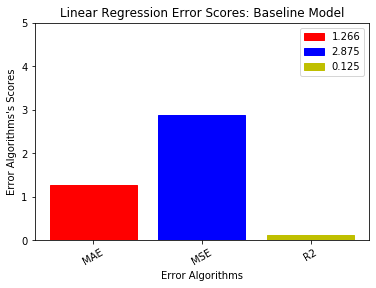

In [5]:
plot_baseline(LinearRegression(n_jobs=-1), 'LinearRegression, error scores (baseline model)', 'Linear Regression Error Scores: Baseline Model')

### Baseline Approach: Bayesian Ridge is model, KNN-based imputation applied

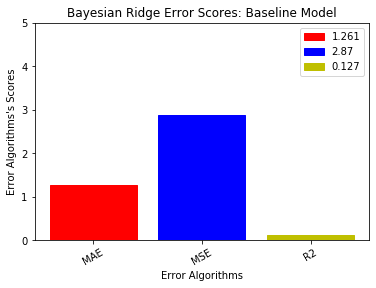

In [6]:
plot_baseline(BayesianRidge(), 'BayesianRidge, error scores (baseline model)', 'Bayesian Ridge Error Scores: Baseline Model')

### Baseline Approach: SVR is model, KNN-based imputation applied

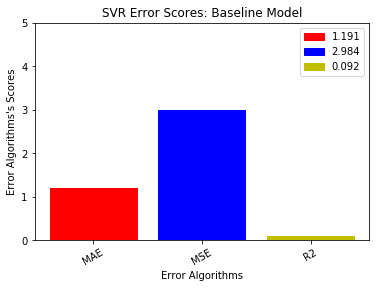

In [7]:
plot_baseline(SVR(), 'SVR, error scores (baseline model)', 'SVR Error Scores: Baseline Model')

### Baseline Approach: KNeighbors is model, KNN-based imputation applied

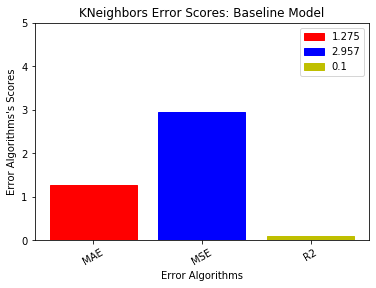

In [8]:
plot_baseline(KNeighborsRegressor(n_neighbors=30, n_jobs=-1), 'KNeighbors, error scores (baseline model)', 'KNeighbors Error Scores: Baseline Model')

### Baseline Approach: ARD is model, KNN-based imputation applied

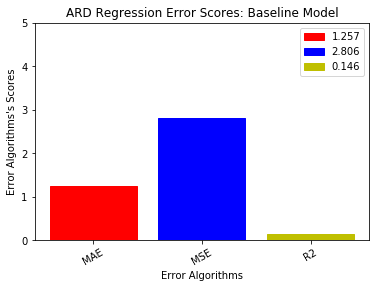

In [9]:
plot_baseline(ARDRegression(), 'ARD, error scores (baseline model)', 'ARD Regression Error Scores: Baseline Model')

### Baseline Approach: SGD is model, KNN-based imputation applied

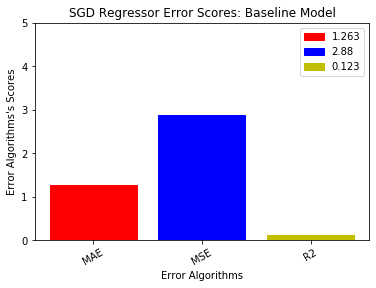

In [10]:
plot_baseline(SGDRegressor(), 'SGD, error scores (baseline model)', 'SGD Regressor Error Scores: Baseline Model')

### Baseline Approach: Majority Voting Regressor, KNN-based imputation applied

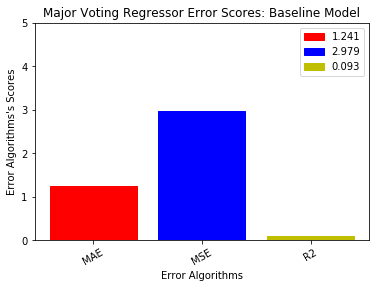

In [11]:
pipe1 = make_pipeline(StandardScaler(), LinearRegression())
clf2 = DecisionTreeRegressor(random_state=0)
pipe3 = make_pipeline(StandardScaler(), KNeighborsRegressor(n_jobs=-1))
mjvoting = VotingRegressor(estimators=[('lr',pipe1), ('dt',clf2), ('knn',pipe3)], n_jobs=-1)
plot_baseline(mjvoting, 'majority voting, error scores (baseline model)', 'Major Voting Regressor Error Scores: Baseline Model')

### Baseline Approach: AdaBoostRegressor is model, KNN-based imputation applied

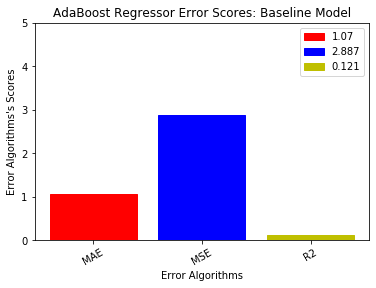

In [12]:
plot_baseline(AdaBoostRegressor(base_estimator=clf2, n_estimators=500, random_state=0), 'adaboost, error scores (baseline model)', 'AdaBoost Regressor Error Scores: Baseline Model')

### Baseline Approach: BaggingRegressor is model, KNN-based imputation applied

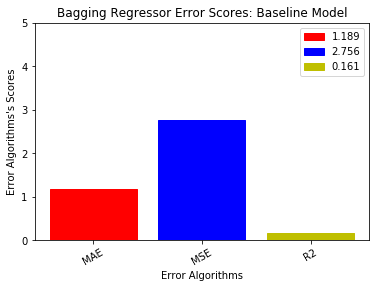

In [13]:
plot_baseline(BaggingRegressor(clf2, n_estimators=500, random_state=0), 'bagging, error scores (baseline model)', 'Bagging Regressor Error Scores: Baseline Model')

### Baseline - X Models Approach

In [14]:
def plot_baseline_X(category, filename, title):
    category_X = np.hstack((category, X))
    X_train, X_test, y_train, y_test = train_test_split(category_X, y, random_state=0, test_size=0.3)
    pipe = make_pipeline(StandardScaler(), BaggingRegressor(clf2, n_estimators=500, random_state=0))
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = round(mean_absolute_error(y_test, y_pred),3)
    mse = round(mean_squared_error(y_test, y_pred),3)
    r2 = round(r2_score(y_test, y_pred),3)
    plotErrorScores(mae, mse, r2, filename, title)

### Baseline - Gender Model

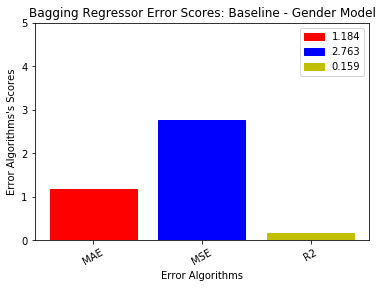

In [15]:
gender = encoded_categorical[:,:2]
plot_baseline_X(gender, 'Bagging, error scores (baseline gender)', 'Bagging Regressor Error Scores: Baseline - Gender Model')

### Baseline - Diagnosis Model

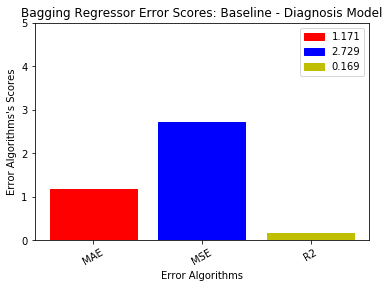

In [16]:
diagnosis = encoded_categorical[:,2:143]
plot_baseline_X(diagnosis, 'Bagging, error scores (baseline diagnosis)', 'Bagging Regressor Error Scores: Baseline - Diagnosis Model')

### Baseline - R/L Model

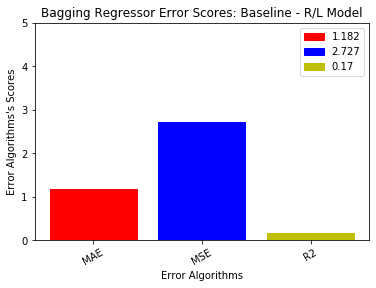

In [17]:
RL = encoded_categorical[:,143:153]
plot_baseline_X(RL, 'Bagging, error scores (baseline RL)', 'Bagging Regressor Error Scores: Baseline - R/L Model')

### Baseline - Procedure Model

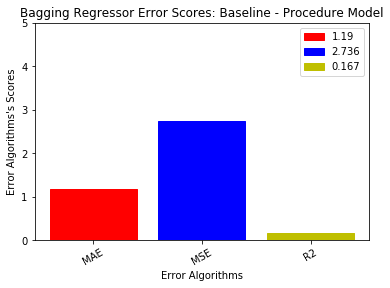

In [18]:
procedure = encoded_categorical[:,153:292]
plot_baseline_X(procedure, 'Bagging, error scores (baseline procedure)', 'Bagging Regressor Error Scores: Baseline - Procedure Model')

### Baseline - Approach Model

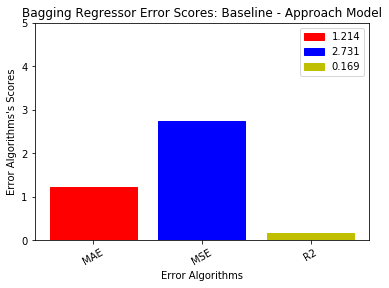

In [19]:
approach = encoded_categorical[:,292:]
plot_baseline_X(approach, 'Bagging, error scores (baseline app model)', 'Bagging Regressor Error Scores: Baseline - Approach Model')

### Baseline - All Categories Model 

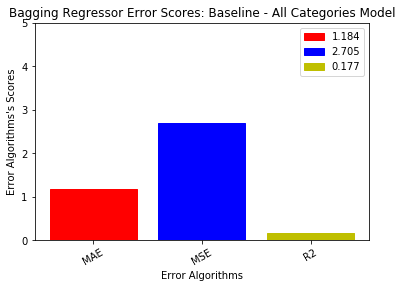

In [20]:
plot_baseline_X(encoded_categorical, 'Bagging, error scores (all dataset)', 'Bagging Regressor Error Scores: Baseline - All Categories Model')